In [1]:
import pandas as pd
import geopandas as gpd
import maup
import time
from maup import smart_repair
from gerrychain import Graph

maup.progress.enabled = True

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Arkansas
state_ab = "ar"

## Data
1. Download all the data in directory "ar_data"
2. Extract them all

In [4]:
data_folder = state_ab + "_data/"
population1_data = "./{}{}_pl2020_b/{}_pl2020_p1_b.shp".format(data_folder, state_ab, state_ab)
population2_data = "./{}{}_pl2020_b/{}_pl2020_p2_b.shp".format(data_folder, state_ab, state_ab)
vap_data =  "./{}{}_pl2020_b/{}_pl2020_p4_b.shp".format(data_folder, state_ab, state_ab)
vest20_data = "./{}{}_vest_20/{}_vest_20.shp".format(data_folder, state_ab, state_ab)
vest18_data = "./{}{}_vest_18/{}_vest_18.shp".format(data_folder, state_ab, state_ab)
vest16_data = "./{}{}_vest_16/{}_vest_16.shp".format(data_folder, state_ab, state_ab)
cd_data = "./{}{}_cong_2021/ak_cong_2021.shp".format(data_folder, state_ab)
send_data = "./{}{}_sldu_adopted_2021/SENATE_DISTRICTS_ADOPTED_2021.shp".format(data_folder, state_ab)
hdist_data = "./{}{}_sldl_2021/ar_sldl_2021.shp".format(data_folder, state_ab)
county_data = "./{}{}_pl2020_cnty/{}_pl2020_cnty.shp".format(data_folder, state_ab, state_ab)

In [5]:
def do_smart_repair(df, min_rook_length = None, snap_precision = 8):
    # change it to the UTM it needs for smart_repair
    df = df.to_crs(df.estimate_utm_crs())
    df = smart_repair(df, min_rook_length = min_rook_length, snap_precision = snap_precision)

    if maup.doctor(df) == False:
        raise Exception('maup.doctor failed')
    
    return df

In [6]:
def add_district(dist_df, dist_name, election_df, col_name):
    election_df = election_df.to_crs(election_df.estimate_utm_crs())
    dist_df = dist_df.to_crs(dist_df.estimate_utm_crs())
    # check if it needs to be smart_repair
    if maup.doctor(dist_df) != True:
        dist_df = do_smart_repair(dist_df)

    # assign the pricincts
    precincts_to_district_assignment = maup.assign(election_df.geometry, dist_df.geometry)
    election_df[dist_name] = precincts_to_district_assignment
    for precinct_index in range(len(election_df)):
        election_df.at[precinct_index, dist_name] = dist_df.at[election_df.at[precinct_index, dist_name], col_name]

    return election_df

In [7]:
def rename(original, year):
    party = original[6]
    if party == 'R' or party == 'D':
        return original[3:6] + year + original[6]
    else:
        return original[3:6] + year + 'O'

In [8]:
pop_col = ['TOTPOP', 'HISP', 'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER', 'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI', 'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP', 'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP']

In [9]:
def check_population(population, df):
    pop_check = pd.DataFrame({
        'pop_col': pop_col,
        'population_df': population[pop_col].sum(), 
        'vest_base': df[pop_col].sum(),
        'equal': [x == y for x, y in zip(population[pop_col].sum(), df[pop_col].sum())]
    })
    if pop_check['equal'].mean() < 1:
        print(pop_check)
        raise Exception("population doesn't agree")

    else:
        print("population agrees")

In [10]:
def add_vest(vest, df, year, population, start_col, snap_precision = 10):
    df = df.to_crs(df.estimate_utm_crs())
    vest = vest.to_crs(vest.estimate_utm_crs())
    population = population.to_crs(population.estimate_utm_crs())
    df_crs = df.crs
    vest_crs = vest.crs
    
     # check if it needs to be smart_repair
    if maup.doctor(vest) != True:
        vest = do_smart_repair(vest, snap_precision = snap_precision)
    
    # rename the columns
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum() # combine all the other party's vote into columns with sufix "O"
    col_name = list(set(new_col))
    col_name.sort()
    
    # make the blocks from precincts by weight
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)
    election_in_block = population[["VAP", 'geometry']] # population_df is in block scale
    blocks_to_precincts_assignment = maup.assign(election_in_block.geometry, vest.geometry)
    weights = election_in_block["VAP"] / blocks_to_precincts_assignment.map(election_in_block["VAP"].groupby(blocks_to_precincts_assignment).sum())
    weights = weights.fillna(0)
    prorated = maup.prorate(blocks_to_precincts_assignment, vest[col_name], weights)
    election_in_block[col_name] = prorated
    
    # assign blocks to precincts
    election_in_block = gpd.GeoDataFrame(election_in_block, crs=vest_crs)
    df = gpd.GeoDataFrame(df, crs=df_crs)
    block_to_pricinct_assginment = maup.assign(election_in_block.geometry, df.geometry)
    df[col_name] = election_in_block[col_name].groupby(block_to_pricinct_assginment).sum()
    df = df.groupby(level=0, axis=1).sum()
    df = gpd.GeoDataFrame(df, crs = df_crs)
    # check if population agrees
    check_population(population, df)
    
    return df

In [11]:
def add_vest_base(vest, start_col, year, county = None, min_rook_length = None, snap_precision = 10):
    vest = vest.to_crs(vest.estimate_utm_crs())
    vest_crs = vest.crs
    original_col = vest.columns[start_col:-1]
    new_col = [rename(i, year) for i in original_col]
    rename_dict = dict(zip(original_col, new_col))
    vest = vest.rename(columns=rename_dict)
    vest = vest.groupby(level=0, axis=1).sum()
    vest = gpd.GeoDataFrame(vest, crs=vest_crs)

    if county is not None:
        county = county.to_crs(county.estimate_utm_crs())
        vest = smart_repair(vest, nest_within_regions = county, min_rook_length = min_rook_length, snap_precision = snap_precision) # nest precincts within counties

    else:
        vest = smart_repair(vest, min_rook_length = min_rook_length, snap_precision = snap_precision) 
    
    return vest

In [12]:
def check_small_boundary_lengths(vest_base):
    import copy
    vest_base = vest_base.to_crs(vest_base.estimate_utm_crs())

    boundaries = copy.deepcopy(vest_base)
    boundaries["geometry"] = boundaries.geometry.boundary  # get boundaries
    neighbors = gpd.sjoin(boundaries, vest_base, predicate="intersects") # find boundaries that intersect
    neighbors = neighbors[neighbors.index != neighbors.index_right] # remove boundaries of a region with itself

    # compute shared border length using intersection
    borders = list(neighbors.apply(
        lambda row: row.geometry.intersection(vest_base.loc[row.index_right, "geometry"]).length, axis=1
    ))

    borders.sort()
    
    return borders

### Read the census data

In [13]:
population1_df = gpd.read_file(population1_data)
population2_df = gpd.read_file(population2_data)
vap_df = gpd.read_file(vap_data)
county_df = gpd.read_file(county_data)

In [14]:
population2_df = population2_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])
vap_df = vap_df.drop(columns=['SUMLEV', 'LOGRECNO', 'GEOID', 'COUNTY', 'geometry'])

In [15]:
population_df = pd.merge(population1_df, population2_df, on='GEOID20')
population_df = pd.merge(population_df, vap_df, on='GEOID20')
population_df = population_df.to_crs(population_df.estimate_utm_crs())

In [16]:
maup.doctor(population_df)

100%|█████████████████████████████████| 136422/136422 [00:58<00:00, 2326.30it/s]


True

In [17]:
population_df['H_WHITE'] = population_df.apply(lambda t: t['P0010003'] - t['P0020005'], 1)
population_df['H_BLACK'] = population_df.apply(lambda t: t['P0010004'] - t['P0020006'], 1)
population_df['H_AMIN'] = population_df.apply(lambda t: t['P0010005'] - t['P0020007'], 1)
population_df['H_ASIAN'] = population_df.apply(lambda t: t['P0010006'] - t['P0020008'], 1)
population_df['H_NHPI'] = population_df.apply(lambda t: t['P0010007'] - t['P0020009'], 1)
population_df['H_OTHER'] = population_df.apply(lambda t: t['P0010008'] - t['P0020010'], 1)
population_df['H_2MORE'] = population_df.apply(lambda t: t['P0010009'] - t['P0020011'], 1)

In [18]:
rename_dict = {'P0020001': 'TOTPOP', 'P0020002': 'HISP', 'P0020005': 'NH_WHITE', 'P0020006': 'NH_BLACK', 'P0020007': 'NH_AMIN',
                    'P0020008': 'NH_ASIAN', 'P0020009': 'NH_NHPI', 'P0020010': 'NH_OTHER', 'P0020011': 'NH_2MORE',
                    'P0040001': 'VAP', 'P0040002': 'HVAP', 'P0040005': 'WVAP', 'P0040006': 'BVAP', 'P0040007': 'AMINVAP',
                                        'P0040008': 'ASIANVAP', 'P0040009': 'NHPIVAP', 'P0040010': 'OTHERVAP', 'P0040011': '2MOREVAP'}

In [19]:
population_df.rename(columns=rename_dict, inplace = True)

Make sure that the County shapefile is clean:

In [20]:
maup.doctor(county_df)

100%|██████████████████████████████████████████| 75/75 [00:00<00:00, 216.49it/s]


True

## Read the vest 20 data

Now using it as a "base pricinct"

## Check if vest20 can be used as base

In [21]:
vest20 = gpd.read_file(vest20_data)

In [22]:
vest20.columns

Index(['STATE_FIPS', 'COUNTY_FIP', 'COUNTY_NAM', 'PRECINCT', 'G20PRERTRU',
       'G20PREDBID', 'G20PRELJOR', 'G20PREGHAW', 'G20PRECBLA', 'G20PREACAR',
       'G20PREOMYE', 'G20PRESLAR', 'G20PREIWES', 'G20PREICOL', 'G20PREIPIE',
       'G20PREIGAM', 'G20PREIFUE', 'G20USSRCOT', 'G20USSDHAR', 'geometry'],
      dtype='object')

In [23]:
start_col = 4
vest_base_data = vest20
year = '20'

In [24]:
vest_base = add_vest_base(vest_base_data, start_col, year, county=county_df)

100%|██████████████████████████████████████████| 75/75 [00:00<00:00, 203.03it/s]


Snapping all geometries to a grid with precision 10^( -5 ) to avoid GEOS errors.


100%|███████████████████████████████████████████| 75/75 [00:01<00:00, 52.20it/s]


Identifying overlaps...


100%|███████████████████████████████████| 77385/77385 [00:58<00:00, 1330.39it/s]


Resolving overlaps and filling gaps...


Gaps to simplify in region 29: 100%|████████| 2552/2552 [02:15<00:00, 18.85it/s]
Gaps to fill: 0it [00:00, ?it/s]
Gaps to fill in region 43: 100%|██████████████████| 9/9 [00:00<00:00, 26.82it/s]
Gaps to simplify in region 44: 1726it [00:33, 50.78it/s]                        
Gaps to fill in region 74: 100%|██████████████████| 7/7 [00:00<00:00, 28.53it/s]


In [25]:
borders = check_small_boundary_lengths(vest_base)
print(borders[:1700])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [26]:
vest_base = do_smart_repair(vest_base, min_rook_length = 30.5)

Snapping all geometries to a grid with precision 10^( -3 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 2910/2910 [00:00<00:00, 3339.59it/s]


Resolving overlaps...
Assigning order 2 pieces...
Assigning order 3 pieces...
Filling gaps...


Gaps to simplify: 0it [00:00, ?it/s]
Gaps to fill: 0it [00:00, ?it/s]


Converting small rook adjacencies to queen...


100%|██████████████████████████████████████| 2591/2591 [00:02<00:00, 870.52it/s]


In [27]:
maup.doctor(vest_base)

100%|██████████████████████████████████████| 2591/2591 [00:02<00:00, 907.42it/s]


True

## If it is true for maup doctor, we will use it as the base vest data.

In [28]:
# vap and population have the same GEOID20
blocks_to_precincts_assignment = maup.assign(population_df.geometry, vest_base.geometry)

100%|██████████████████████████████████████| 2591/2591 [00:15<00:00, 169.58it/s]


In [29]:
vest_base[pop_col] = population_df[pop_col].groupby(blocks_to_precincts_assignment).sum()

In [30]:
election_df = gpd.GeoDataFrame(vest_base)

In [31]:
election_df.columns

Index(['COUNTY_FIP', 'COUNTY_NAM', 'PRE20D', 'PRE20O', 'PRE20R', 'PRECINCT',
       'STATE_FIPS', 'USS20D', 'USS20R', 'geometry', 'TOTPOP', 'HISP',
       'NH_WHITE', 'NH_BLACK', 'NH_AMIN', 'NH_ASIAN', 'NH_NHPI', 'NH_OTHER',
       'NH_2MORE', 'H_WHITE', 'H_BLACK', 'H_AMIN', 'H_ASIAN', 'H_NHPI',
       'H_OTHER', 'H_2MORE', 'VAP', 'HVAP', 'WVAP', 'BVAP', 'AMINVAP',
       'ASIANVAP', 'NHPIVAP', 'OTHERVAP', '2MOREVAP'],
      dtype='object')

## Check if population agrees

In [32]:
check_population(population_df, vest_base)

population agrees


## Add more vest data

In [33]:
vest18 = gpd.read_file(vest18_data)
vest16 = gpd.read_file(vest16_data)

In [34]:
vest18.columns

Index(['COUNTY_FIP', 'COUNTY_NAM', 'PRECINCT', 'G18GOVRHUT', 'G18GOVDHEN',
       'G18GOVLWES', 'G18LTGRGRI', 'G18LTGDBLA', 'G18LTGLGIL', 'G18ATGRRUT',
       'G18ATGDLEE', 'G18ATGLHIC', 'G18SOSRTHU', 'G18SOSDINM', 'G18SOSLOLS',
       'G18TRERMIL', 'G18TRELEWA', 'G18AUDRLEA', 'G18AUDLDIN', 'G18LNDRLAN',
       'G18LNDDWIL', 'G18LNDLCAM', 'geometry'],
      dtype='object')

In [35]:
vest16.columns

Index(['COUNTY_FIP', 'COUNTY_NAM', 'PRECINCT', 'G16PRERTRU', 'G16PREDCLI',
       'G16PRELJOH', 'G16PREOMCM', 'G16PREGSTE', 'G16PREIHED', 'G16PRECCAS',
       'G16PREIKAH', 'G16USSRBOO', 'G16USSDELD', 'G16USSLGIL', 'G16USSOWRI',
       'geometry'],
      dtype='object')

In [36]:
# check the result here
start_col = 3
election_df = add_vest(vest18, election_df, '18', population_df, start_col, snap_precision=8)

100%|██████████████████████████████████████| 2617/2617 [00:03<00:00, 854.52it/s]


There are 121 overlaps.
There are 626 holes.
There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -3 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 3769/3769 [00:01<00:00, 2361.42it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


100%|██████████████████████████████████████| 2591/2591 [00:14<00:00, 176.83it/s]


population agrees


In [37]:
start_col = 3
election_df = add_vest(vest16, election_df, '16', population_df, start_col, snap_precision=8)

100%|██████████████████████████████████████| 2525/2525 [00:02<00:00, 925.50it/s]


There are 147 overlaps.
There are 815 holes.
There are some invalid geometries.
Snapping all geometries to a grid with precision 10^( -3 ) to avoid GEOS errors.
Identifying overlaps...


100%|█████████████████████████████████████| 3864/3864 [00:00<00:00, 4029.60it/s]


Resolving overlaps...
Assigning order 2 pieces...
Filling gaps...


100%|██████████████████████████████████████| 2591/2591 [00:14<00:00, 184.56it/s]


population agrees


##  Add the district data

In [38]:
cd = gpd.read_file(cd_data)
cd = cd.to_crs(cd.estimate_utm_crs())
send = gpd.read_file(send_data)
send = send.to_crs(send.estimate_utm_crs())
hdist = gpd.read_file(hdist_data)
hdist = hdist.to_crs(hdist.estimate_utm_crs())

In [39]:
cd.head()

,ID,DISTRICT,DISTRICTN,geometry
0,1,1,1,"POLYGON ((606123.904 3773088.021, 606459.009 3..."
1,2,2,2,"POLYGON ((517571.181 3826170.575, 517572.197 3..."
2,3,3,3,"POLYGON ((396163.763 3887937.789, 396016.742 3..."
3,4,4,4,"POLYGON ((368873.493 3892128.791, 368876.673 3..."


In [40]:
election_df = add_district(cd, "CD", election_df, "DISTRICT")

100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  5.33it/s]


In [41]:
send.head()

,objectid,id,district,districtn,st_area(sh,st_length(,geometry
0,36,1,1,1.0,1.098196e+10,781762.354242,"POLYGON ((671266.595 3653254.481, 671147.816 3..."
1,37,2,2,2.0,8.782117e+09,673477.622005,"POLYGON ((501657.882 3678621.624, 501658.439 3..."
2,38,3,3,3.0,9.699264e+09,678299.140530,"POLYGON ((498390.386 3653206.732, 498355.736 3..."
3,39,4,4,4.0,6.782729e+09,580337.546669,"POLYGON ((402931.937 3689887.422, 402942.053 3..."
4,40,5,5,5.0,1.250595e+10,733191.551857,"POLYGON ((458710.203 3781632.405, 458685.972 3..."


In [43]:
election_df = add_district(send, "SEND", election_df, "district")

100%|███████████████████████████████████████████| 35/35 [00:01<00:00, 20.61it/s]


In [44]:
hdist.head()

,ID,DISTRICT,DISTRICTN,geometry
0,1,1,1,"POLYGON ((717643.782 3989881.400, 717602.679 3..."
1,2,2,2,"POLYGON ((673390.938 3998407.649, 673389.407 3..."
2,3,3,3,"POLYGON ((542169.916 4039347.650, 542553.294 4..."
3,4,4,4,"POLYGON ((509834.473 3996625.542, 509838.835 3..."
4,5,5,5,"POLYGON ((509834.473 3996625.542, 508821.258 3..."


In [45]:
election_df = add_district(hdist, "HDIST", election_df, "DISTRICT")

100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 46.55it/s]


In [46]:
maup.doctor(election_df)

100%|██████████████████████████████████████| 2591/2591 [00:03<00:00, 854.62it/s]


True

### Put the base precinct year after the precinct information column

In [47]:
base_columns = {}
if 'COUNTY_FIP' + year not in election_df.columns:
    base_columns = {
        'COUNTY_FIP':'COUNTY_FIP'+year,
        'COUNTY_NAM':'COUNTY_NAM'+year,
        'PRECINCT':'PRECINCT'+year,
        'STATE_FIPS':'STATE_FIPS'+year,
    }
election_df.rename(columns=base_columns, inplace = True)

In [48]:
# reorder the columns
fixed_columns = [
    'COUNTY_FIP'+year,
    'COUNTY_NAM'+year,
    'PRECINCT'+year,
    'STATE_FIPS'+year,
    'CD',
    'SEND',
    'HDIST',
    'TOTPOP',
    'NH_2MORE',
    'NH_AMIN',
    'NH_ASIAN',
    'NH_BLACK',
    'NH_NHPI',
    'NH_OTHER',
    'NH_WHITE',
    'HISP',
    'H_AMIN',
    'H_ASIAN',
    'H_BLACK',
    'H_NHPI',
    'H_OTHER',
    'H_WHITE',
    'H_2MORE',
    'VAP',
    'HVAP',
    'WVAP',
    'BVAP',
    'AMINVAP',
    'ASIANVAP',
    'NHPIVAP',
    'OTHERVAP',
    '2MOREVAP']

election_columns = [col for col in election_df.columns if col not in fixed_columns]
final_col = fixed_columns + election_columns
election_df = election_df[final_col]

In [49]:
import os

# store the result in directory "il"
directory = "./{}".format(state_ab)
if not os.path.exists(directory):
    os.makedirs(directory)

shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
geojson_path = './{}/{}.geojson'.format(state_ab, state_ab)
json_path = "./{}.json".format(state_ab, state_ab)

# Check if the shapefile or geojson file already exists
if os.path.exists(shapefile_path):
    os.remove(shapefile_path)
if os.path.exists(geojson_path):
    os.remove(geojson_path)

election_df.to_file(shapefile_path)
election_df.to_file(geojson_path, driver='GeoJSON')

# Only do once to build json and read from file when generating ensembles
graph = Graph.from_file(shapefile_path, ignore_errors=True)
graph.to_json(json_path)

<Axes: >

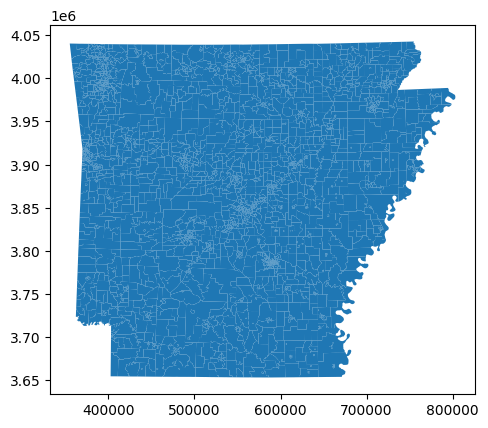

In [50]:
shapefile_path = "./{}/{}.shp".format(state_ab, state_ab)
shape=gpd.read_file(shapefile_path)
shape.plot()